<a id='table_of_contents'></a>

0. [Import libraries](#imports)
1. [Import data](#import_data)
2. [Data transformation](#data_transformation)
3. [Data exploration](#data_exploration)
4. [Data preparation](#data_preparation)
5. [Data examinatino](#data_examination)
5. [Benchmark model](#benchmark_model)<br>
6. [Model training](#model_training)<br>
7. [Tuning](#tuning)<br>

# 0. Import libraries <a id='imports'></a>
[Back to top](#table_of_contents)

In [98]:
import os
import pandas as pd
import numpy as np
from datetime import datetime
from datetime import timedelta
import matplotlib.pyplot as plt
%matplotlib inline
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.tsa.arima_model import ARIMA as ARIMA
import statsmodels.api as sm
import statsmodels.tsa.api as smt
from statsmodels.tsa.seasonal import STL




# 1. Import data <a id='import_data'></a>
[Back to top](#table_of_contents)

In [12]:
print(os.getcwd())
# return datatime
def parser(s):
    return datetime.strptime(s, '%Y-%m')


airpassenger = pd.read_csv('AirPassengers.csv', parse_dates= [0], index_col= 0, date_parser= parser, header= [0])


d:\Main\Data-Analysis\AirPassengerForecast


C:\Users\bakbarza\AppData\Local\Temp\ipykernel_23748\1494554016.py:7: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  airpassenger = pd.read_csv('AirPassengers.csv', parse_dates= [0], index_col= 0, date_parser= parser, header= [0])


# 2. Data transformation <a id='data_transformation'></a>
[Back to top](#table_of_contents)

In [13]:


airpassenger = airpassenger.asfreq(pd.infer_freq(airpassenger.index))
airpassenger.index

DatetimeIndex(['1949-01-01', '1949-02-01', '1949-03-01', '1949-04-01',
               '1949-05-01', '1949-06-01', '1949-07-01', '1949-08-01',
               '1949-09-01', '1949-10-01',
               ...
               '1960-03-01', '1960-04-01', '1960-05-01', '1960-06-01',
               '1960-07-01', '1960-08-01', '1960-09-01', '1960-10-01',
               '1960-11-01', '1960-12-01'],
              dtype='datetime64[ns]', name='Month', length=144, freq='MS')

# 3. Data exploration <a id='data_exploration'></a>

[Back to top](#table_of_contents)

In [14]:
print(airpassenger.isna().sum())
columnName = airpassenger.columns
print(columnName)
airpassenger.describe()

# if there is nan 

#Passengers    0
dtype: int64
Index(['#Passengers'], dtype='object')


,#Passengers
count,144.000000
mean,280.298611
std,119.966317
min,104.000000
25%,180.000000
50%,265.500000
75%,360.500000
max,622.000000


# 4. Data preparation <a id='data_preparation'></a>
[Back to top](#table_of_contents)

In [15]:
airpassenger = airpassenger.rename(columns = {'#Passengers':'Passengers'})
start_time = datetime(1949, 1, 1)
end_time = datetime(1956, 1, 1)
lim_airpassenger = airpassenger[start_time:end_time]

# 4. Data examination <a id='data_examination'></a>
[Back to top](#table_of_contents)

C:\Users\bakbarza\AppData\Local\Temp\ipykernel_23748\3874105700.py:20: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.axhline(timeSeries.mean()[0], color='r', linestyle='--', alpha=0.2)


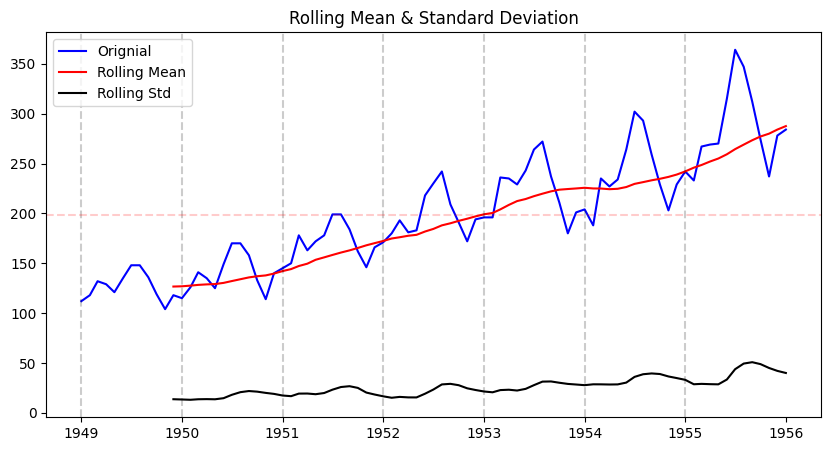

Results of Dickey-Fuller Test:
Test Statistic                  0.919455
p-value                         0.993339
#Lags Used                     12.000000
Number of Observations Used    72.000000
Critical Value (1%)            -3.524624
Critical Value (5%)            -2.902607
Critical Value (10%)           -2.588679
dtype: float64


In [16]:
def test_stationary(timeSeries):
    # the Original
    plt.figure(figsize=(10, 5))
    origin = plt.plot(timeSeries, color = 'blue', label = 'Orignial')


    # Cosntant mean
    MA = timeSeries.rolling(window =12).mean()
    mean = plt.plot(MA, color = 'red', label = 'Rolling Mean')

    # Constant var
    MSTD = timeSeries.rolling(window = 12).std()
    std = plt.plot(MSTD, color = 'black', label = 'Rolling Std')


    # indicate timestamps
    for year in range(pd.to_datetime(timeSeries.index.min()).year, pd.to_datetime(timeSeries.index.max()).year ):
        plt.axvline(pd.to_datetime(str(year)+'-01-01'), color='k', linestyle='--', alpha=0.2)

    plt.axhline(timeSeries.mean()[0], color='r', linestyle='--', alpha=0.2)

    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show()


    # perform Dickey-Fuller test
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeSeries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)


test_stationary(lim_airpassenger)



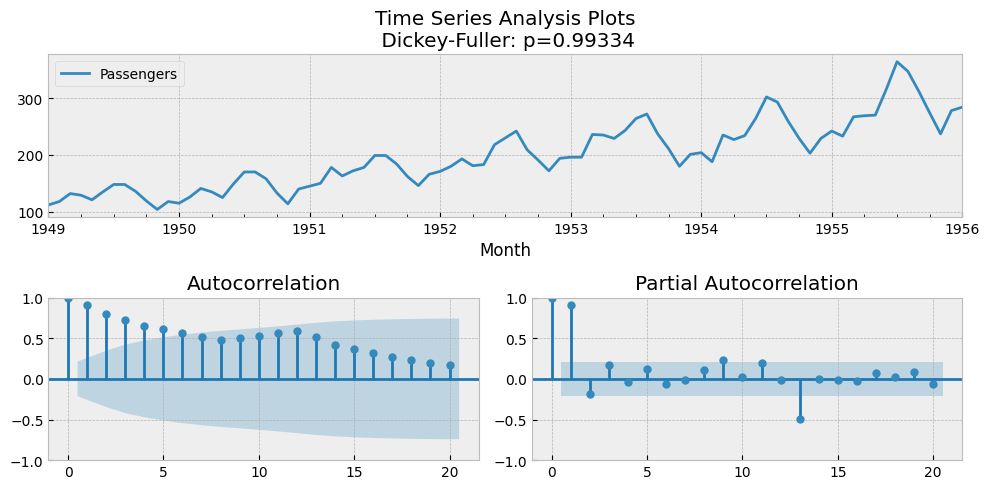

In [31]:
def desplayTimeSeries(timeSeries, lags=None, figsize=(10, 5), style='bmh'):    
    
    with plt.style.context(style):
        fig = plt.figure(figsize= figsize)
        layout = (2, 2)
        ts_ax = plt.subplot2grid(layout, (0, 0), colspan= 2)
        acf_ax = plt.subplot2grid(layout, (1, 0))
        pacf_ax = plt.subplot2grid(layout, (1, 1))

        timeSeries.plot(ax = ts_ax)
        p_value = adfuller(timeSeries)[1]
        ts_ax.set_title('Time Series Analysis Plots\n Dickey-Fuller: p={0:.5f}'.format(p_value))
        smt.graphics.plot_acf(timeSeries, lags=lags, ax=acf_ax)
        smt.graphics.plot_pacf(timeSeries, lags=lags, ax=pacf_ax)
        plt.tight_layout()


desplayTimeSeries(timeSeries= lim_airpassenger)


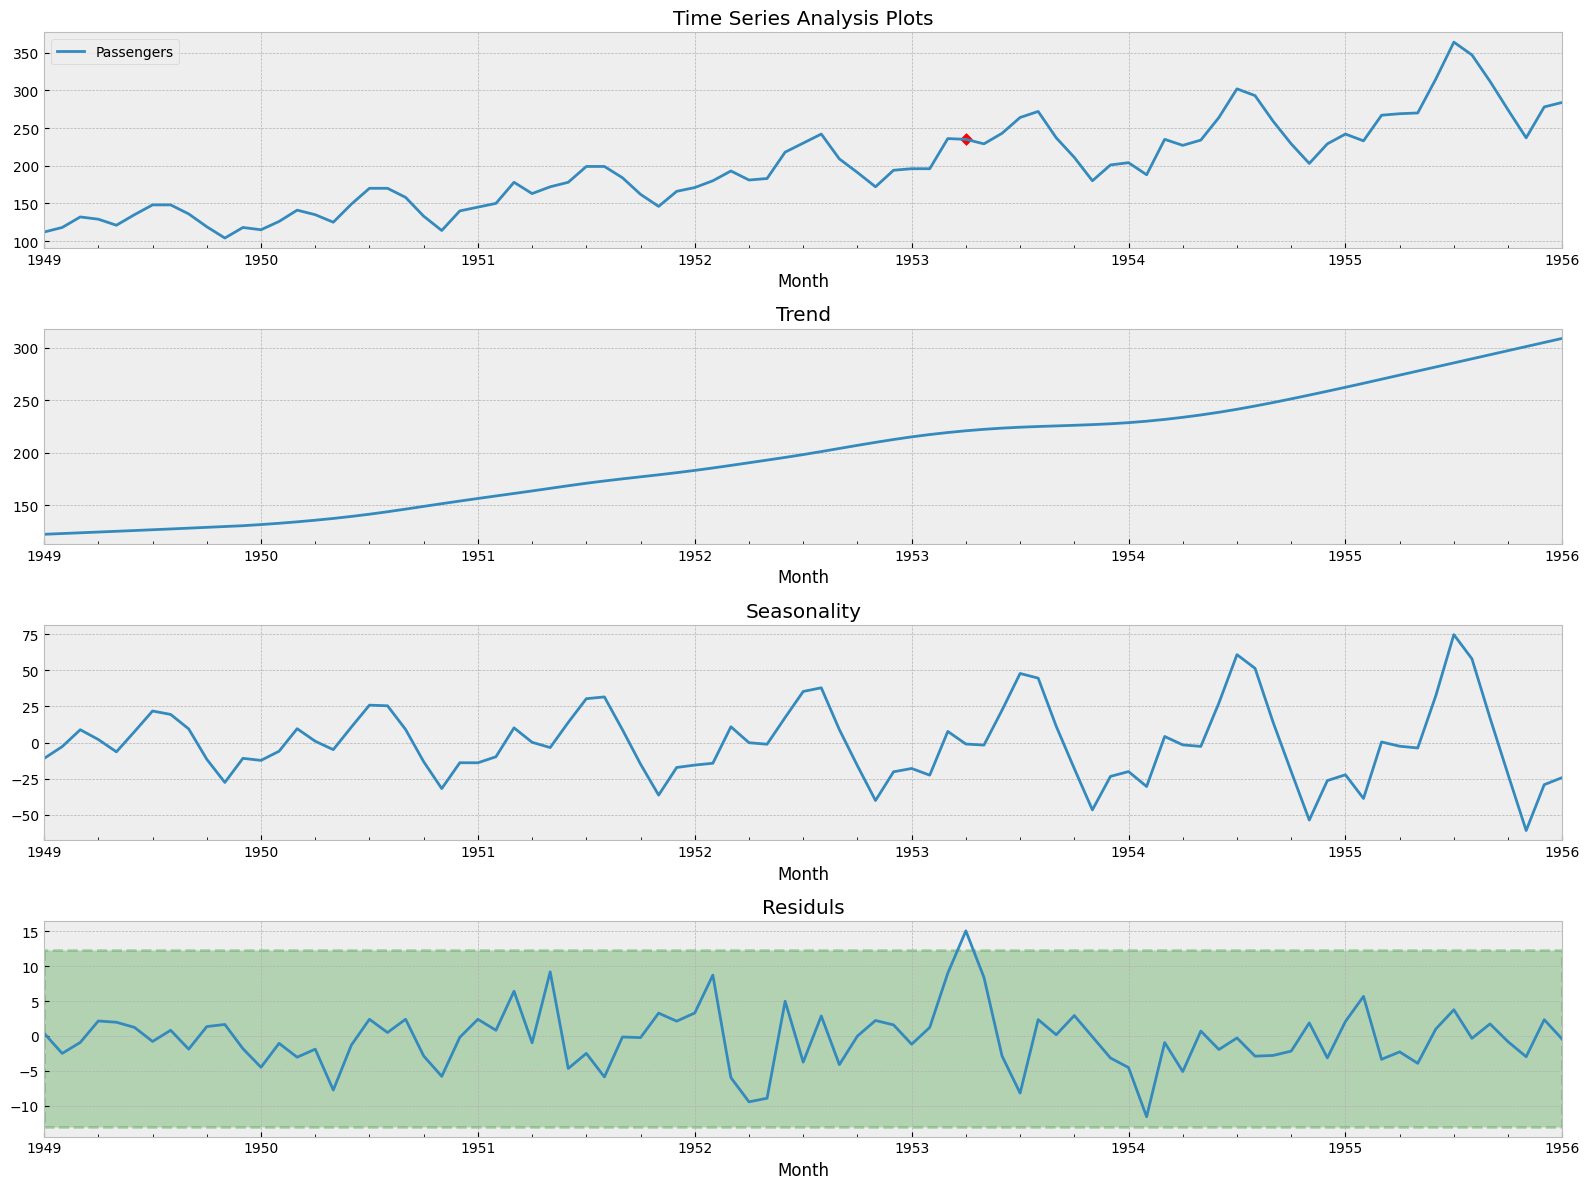

In [83]:
# finding anamually 

def displayDecomposed(timeSeries, figsize=(16, 12), style='bmh'):
    seasonal_trend_dec =  STL(timeSeries)
    stlResult = seasonal_trend_dec.fit()
    seasonal, trend, resid = stlResult.seasonal, stlResult.trend, stlResult.resid

    resid_mu = resid.mean()
    resid_dev = resid.std()
    lower = resid_mu - 2.96*resid_dev
    upper = resid_mu + 2.96*resid_dev
    
    anomalies = timeSeries[(resid < lower) | (resid > upper)]

    with plt.style.context(style):
        fig = plt.figure(figsize= figsize)
        layout = (4, 1)
        ts_ax = plt.subplot2grid(layout, (0, 0))
        tr_ax = plt.subplot2grid(layout, (1, 0))
        ss_ax = plt.subplot2grid(layout, (2, 0))
        rs_ax = plt.subplot2grid(layout, (3, 0))

        timeSeries.plot(ax = ts_ax)
        if len(anomalies) > 0:
            ts_ax.scatter(anomalies.index, timeSeries[timeSeries.columns[0]][anomalies.index], color='r', marker='D')
        ts_ax.set_title('Time Series Analysis Plots')    
        


        trend.plot(ax = tr_ax)
        tr_ax.set_title('Trend')
        seasonal.plot(ax = ss_ax)
        ss_ax.set_title('Seasonality')
        resid.plot(ax = rs_ax)
        rs_ax.fill_between(timeSeries.index ,lower, upper, color='g', alpha=0.25, linestyle='--', linewidth=2)
        
        rs_ax.set_title('Residuls')
        plt.tight_layout()


displayDecomposed(timeSeries= lim_airpassenger)


# 5. Data transformation <a id='data_transformation'></a>
[Back to top](#table_of_contents)

C:\Users\bakbarza\AppData\Local\Temp\ipykernel_23748\1713999730.py:8: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  equalSize_month_avg =  i_airpassenger.index.map(lambda d: month_avgs.loc[d.month][0])
C:\Users\bakbarza\AppData\Local\Temp\ipykernel_23748\3874105700.py:20: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.axhline(timeSeries.mean()[0], color='r', linestyle='--', alpha=0.2)


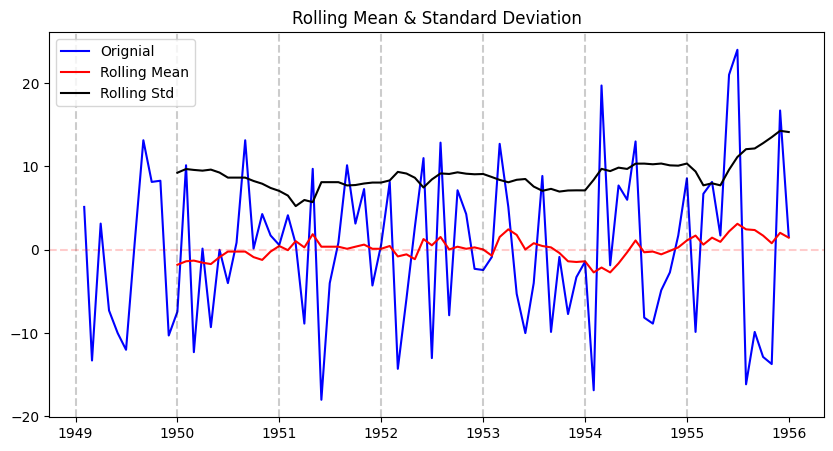

Results of Dickey-Fuller Test:
Test Statistic                -9.540686e+00
p-value                        2.731904e-16
#Lags Used                     0.000000e+00
Number of Observations Used    8.300000e+01
Critical Value (1%)           -3.511712e+00
Critical Value (5%)           -2.897048e+00
Critical Value (10%)          -2.585713e+00
dtype: float64


In [174]:
# Removing trends, first differnece? second diffrences?
i_airpassenger = lim_airpassenger.diff()
i_airpassenger = i_airpassenger.dropna()


# Removing seasonality by deviding to the monthly avarage 
month_avgs = i_airpassenger.groupby(i_airpassenger.index.month).mean()
equalSize_month_avg =  i_airpassenger.index.map(lambda d: month_avgs.loc[d.month][0])
#print(equalSize_month_avg)
# change the index
indexed_equalSize_month_avg = pd.DataFrame( {str(i_airpassenger.columns[0]): equalSize_month_avg}, index= i_airpassenger.index)

i_airpassenger = i_airpassenger - indexed_equalSize_month_avg

test_stationary(timeSeries= i_airpassenger)
#displayDecomposed(timeSeries= i_airpassenger)


    

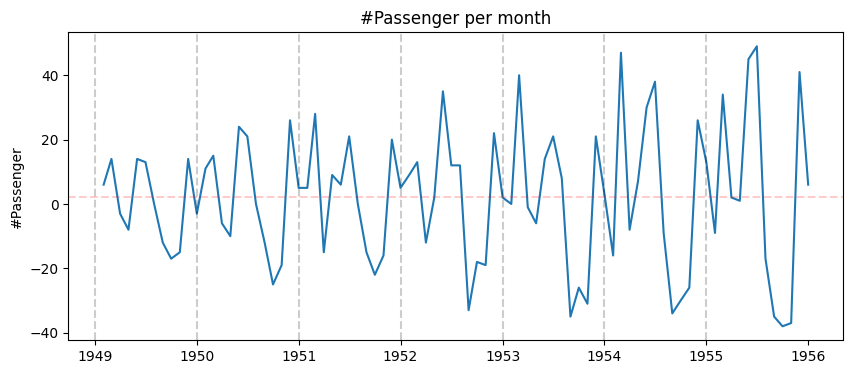

In [ ]:
first_diff = lim_airpassenger.diff()[1:]
plt.figure(figsize = (10, 4))
plt.plot(first_diff)
plt.title('#Passenger per month')
plt.ylabel("#Passenger")


for year in range(start_time.year, end_time.year):
    plt.axvline(pd.to_datetime(str(year) + '-01-01'), color = 'k', linestyle = '--', alpha=0.2)

plt.axhline(first_diff['#Passengers'].mean(), color='r', alpha=0.2, linestyle='--')



# 5. Benchmark model <a id='benchmark_model'></a>
[Back to top](#table_of_contents)

# 6. Feature engineering <a id='feature_engineering'></a>
[Back to top](#table_of_contents)

# 7. Model training <a id='model_training'></a>
[Back to top](#table_of_contents)

## 7.1. Decision tree <a id='decision_tree'></a>

## 7.2. Random forest <a id='random_forest'></a>

## 7.3. Comparing algorithm performances <a id='comparing_algorithm_performances'></a>

# 8. Tuning <a id='tuning'></a>
[Back to top](#table_of_contents)

# 3. Data cleaning <a id='data_cleaning'></a>
[Back to top](#table_of_contents)

# 4. Data preparation <a id='data_preparation'></a>
[Back to top](#table_of_contents)

# 5. Benchmark model <a id='benchmark_model'></a>
[Back to top](#table_of_contents)

# 6. Feature engineering <a id='feature_engineering'></a>
[Back to top](#table_of_contents)

# 7. Model training <a id='model_training'></a>
[Back to top](#table_of_contents)

## 7.1. Decision tree <a id='decision_tree'></a>

## 7.2. Random forest <a id='random_forest'></a>

## 7.3. Comparing algorithm performances <a id='comparing_algorithm_performances'></a>

# 8. Tuning <a id='tuning'></a>
[Back to top](#table_of_contents)